## Vision

### To run


In [2]:
cap = cv2.VideoCapture(0)
frame_count = 0

grilles = Grid()

finished = False

NameError: name 'cv2' is not defined

### To show


Once the camera is up and running, we have to go through several steps :

- detect the anchors : 4 pink squares that define the region of interest
- detect the color circles which correspond to the targets the robot has to reach
- detect the obstacles the robot has to avoid
- detect the robot to get its initial position

The detection of the circles and the obstacles is run continuously until we detect these object several times, in order to average the measures to avoid incorrect detections.
If the detection takes too much time (>6s), because of incorrect detections or missing objects, the process restarts by itself until everything is detected.

Once these fixed objects are detected, we set the grid accordingly and we can then try to detect the robot. The while loop is at the center of the program and gets a frame for each iteration. The robot detecting function is then called : we give it the frame and it returns the annotated frame + the robot position and angle.

Another functions runs in parallel to check if the robot has reached the target, by comparing their centers


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys

# Define the list of boundaries
colors = {
    'yellow': ([0, 123, 240], [41, 255, 255], -5, [0, 255, 255]), #2, -5
}

filename = "test.png"
frame = cv2.imread(filename)

if frame is None:
    print(f"L'image {filename} n'a pas pu être chargée.")
    sys.exit()

The pipeline of image processing for object detection is the following : 
- once the hsv frame is obtained, we apply a gaussian blur to prepare the image for edge detection and median blur to reduce the noise
- we create a mask with the range of hsv values defined for the color we want to detect. The tuning of the ranges is an important step done before the demonstration. For this we use the function calib_hvs.py in which we can experiment different values for H,S and V thresholds.
- we apply a closing operation :  dilation to fill the small holes then erosion to set it back to the right size and remove tiny regions
- cv2.connectedComponentsWithStats to get the continous objects
- cv2.findContours to get the contours of the detected objects


This methods allows even small regions are detected and identified as contours. Hence, depending on the object, we apply conditions on the number of edges and the area. It allows to differentiate between noisy regions where a false object could be detected and the real object.

In this example, the thresholding is almost perfect as we don't see any other region in the masks.

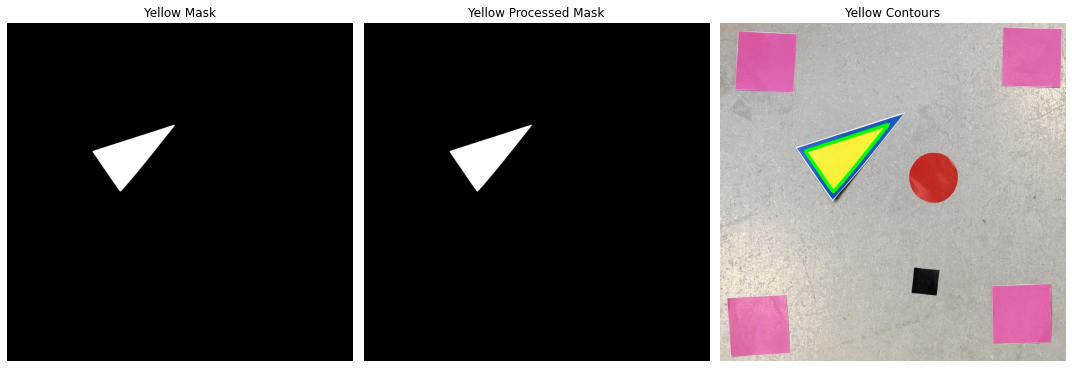

In [21]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
hsv = cv2.GaussianBlur(hsv, (5, 5), 0)
hsv = cv2.medianBlur(hsv, 5)
kernel = np.ones((5, 5), np.uint8)

color_name = 'yellow'
lower, upper, _, display_color = colors[color_name]
lower = np.array(lower, dtype=np.uint8)
upper = np.array(upper, dtype=np.uint8)

mask = cv2.inRange(hsv, lower, upper)
dilation = cv2.dilate(mask, kernel, iterations=2)
erosion = cv2.erode(dilation, kernel, iterations=2)

num_labels, labels = cv2.connectedComponents(erosion)

contour_image = frame.copy()

for label in range(1, num_labels):  # label 0 is the background
    component_mask = (labels == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), thickness=20)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mask, cmap="gray")
axes[0].set_title(f"{color_name.capitalize()} Mask")
axes[0].axis("off")

axes[1].imshow(erosion, cmap="gray")
axes[1].set_title(f"{color_name.capitalize()} Processed Mask")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[2].set_title(f"{color_name.capitalize()} Contours")
axes[2].axis("off")

plt.tight_layout()
plt.show()


When we try to detect the black polygon, representing an obstacle, we are most interested in the convex hull of the polygon. Considering this hull is benefic for us because it will avoid the robot falling in traps inside the hull.
Before getting this hull, we want to enlarge the polygon to add some margin on the sides of the polygon, so that the robot can smoothly avoid the obstacle.
This is done with this function, which computes the normals of the faces at each vertex.

In [18]:
def enlarge_polygon(vertices, margin=15):
    enlarged_vertices = []
    num_vertices = len(vertices)

    for i in range(num_vertices):
        # for each vertex, get the previous and next vertex, then the edge vectors and the normal
        prev_idx = (i - 1) % num_vertices
        next_idx = (i + 1) % num_vertices

        edge1 = vertices[i] - vertices[prev_idx]
        edge2 = vertices[next_idx] - vertices[i]

        edge1_normalized = np.array([-edge1[1], edge1[0]], dtype=np.float64)
        edge2_normalized = np.array([-edge2[1], edge2[0]], dtype=np.float64)

        edge1_normalized /= np.linalg.norm(edge1_normalized)
        edge2_normalized /= np.linalg.norm(edge2_normalized)

        normal = 0.5*(edge1_normalized + edge2_normalized)
        enlarged_vertex = vertices[i] + margin * normal
        enlarged_vertices.append(enlarged_vertex)

    return np.array(enlarged_vertices, dtype=np.int32)

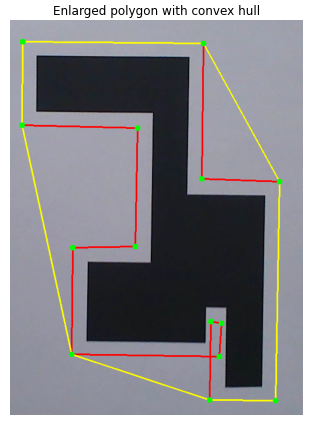

To enhance performances, we do not want to apply our image processing techniques on the whole frame captured by the camera. This is why we use the 4 square anchors that define the region of interest. Once they are detected, we are sistematically cropping the frame to the defined region. 
While setting up the scene, we pay attention to dispose the anchors in a rectangular pattern, so we don't need to reorient the frame with a transformation.

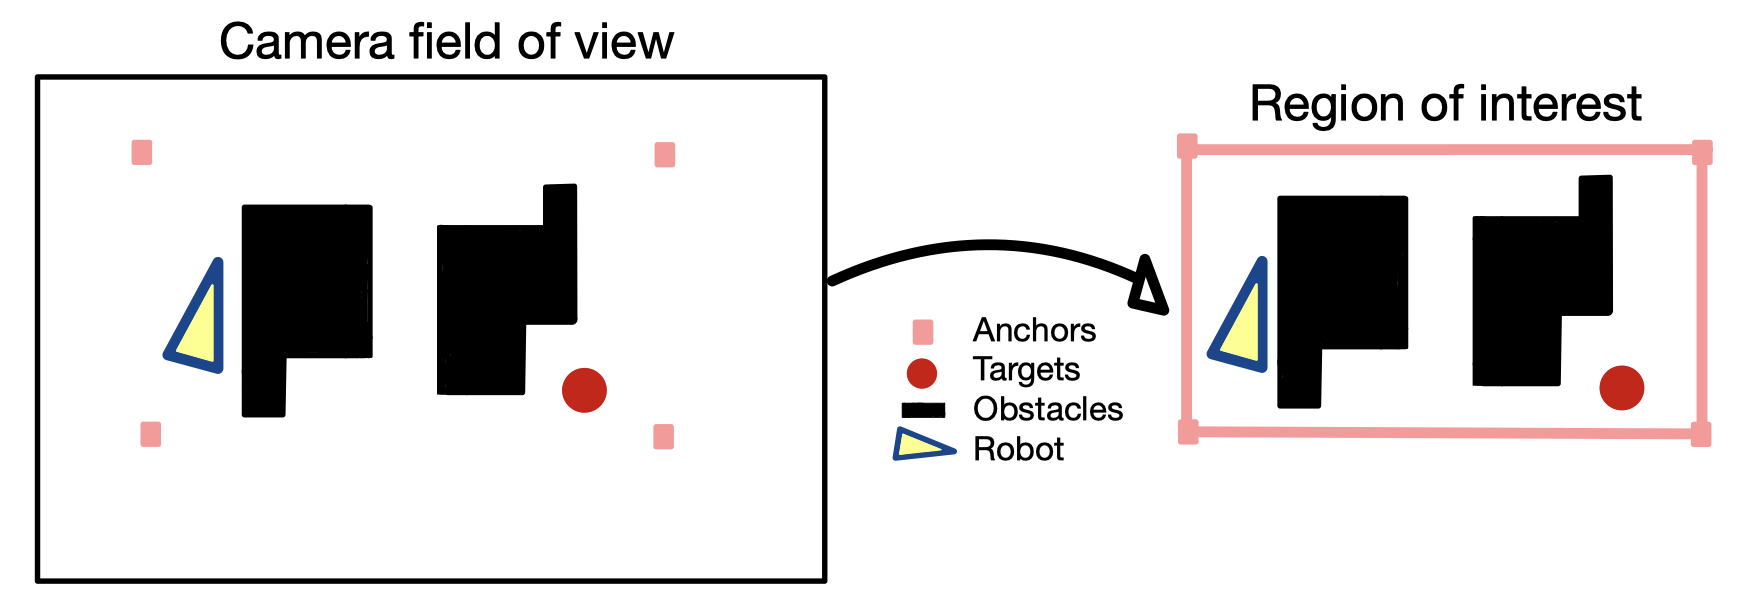

Using a triangle to represent the robot allows us to get both the position and the robot orientation. The triangle is designed in a way that the smallest side is the one opposing the tip of the triangle.
By computing the center of this side and the center of the full triangle, we get a line joining the front vertex and the midpoint of the back side. We can then compute its orientation.

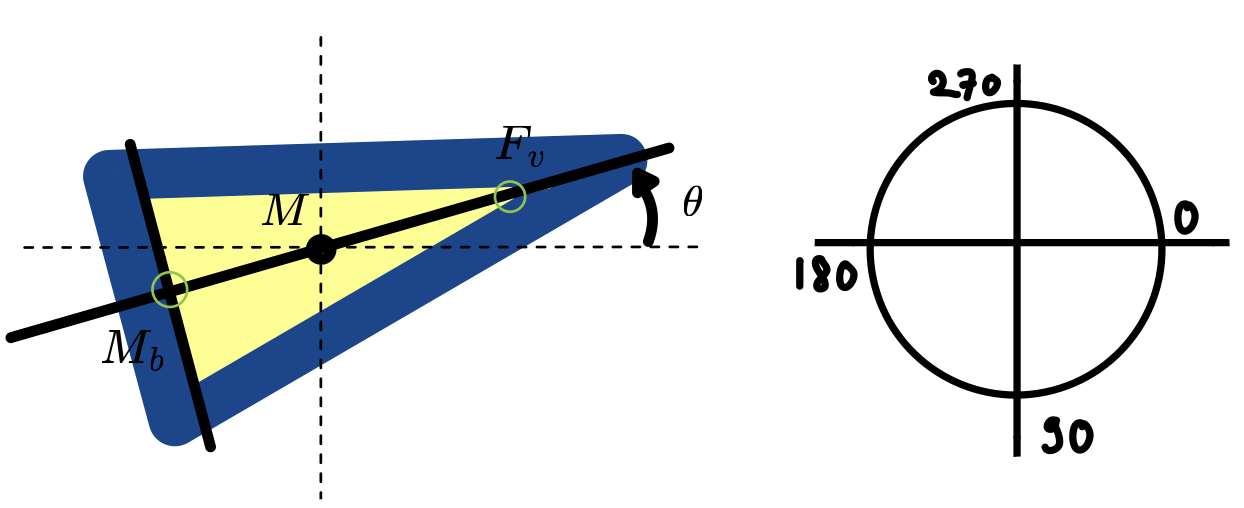

In order to avoid the detection errors occuring while detecting the objects, we smooth the values obtained by doing an average on the positions and shapes of the objects.
- For the robot : we take the average of the last 2 detections and we assume that the robot is not moving super fast so once it's detected in a speific region, it will stay in a certain circle around its last position.
- For the circles : we have to detect each circle 20 times to set their position and radii.
- For the obstacles : each obstacle has to be detected at least 10 times to ensure that we got its vertices correctly

Once the circles, the obstacles and the initial position of the robot have been detected, we can pass the obstacle grid and the different positions to the rest of the code.



PARLER DES 3 DIFFERENTS ESPACES

### Biblio

https://docs.opencv.org/3.4/d3/dbe/tutorial_opening_closing_hats.html

https://www.geeksforgeeks.org/python-opencv-connected-component-labeling-and-analysis/